# Group level statistics


## Retrieving First-Level results
As we now have the same contrast results from multiple `subjects`, we can define our `group level model`. First, we need to gather the `individual contrast maps`.

In [91]:
import os
import glob
from bids.layout import BIDSLayout

ds_path = '../data'
results_path = '../results'

# Initialize the BIDS layout and include the derivatives in it
layout = BIDSLayout(ds_path, derivatives = True)

# Attach the results folder to the layout. It must complay with BIDS standards. 
# And must include dataset_description.json file!
layout.add_derivatives(os.path.join(results_path, "first-level"))

We will collect individual t-maps (`stat`) that represent the BOLD activity estimate divided by the uncertainty about this estimate. 

We will first look at only the **Faces > Scrambled** contrast. 

In [92]:
contrast = 'FacesScrambled'
stat_files = layout.get(desc = contrast, suffix='stat', extension = '.nii.gz', return_type='filename')
print(*stat_files, sep = "\n")

/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-01/sub-01_task-facerecognition_desc-FacesScrambled_stat.nii.gz
/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-02/sub-02_task-facerecognition_desc-FacesScrambled_stat.nii.gz
/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-03/sub-03_task-facerecognition_desc-FacesScrambled_stat.nii.gz
/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-04/sub-04_task-facerecognition_desc-FacesScrambled_stat.nii.gz
/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-05/sub-05_task-facerecognition_desc-FacesScrambled_stat.nii.gz
/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-06/sub-06_task-facerecognition_desc-FacesScrambled_stat.nii.gz
/imaging/correia/da05/workshops/2024-CBU/notebooks/../results/first-level/sub-07/sub-07_task-facerecognition_desc-FacesScrambled_stat.nii.gz
/imaging/corr

We will want to display subject ID on top of their individual t-maps. Therefore we need to link each stat file with the corresponding subject ID. The simplest seems to retrieve the subject list from the BIDS layout.

In [93]:
subjects = layout.get_subjects()
print(subjects)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']


## Displaying subject t-maps

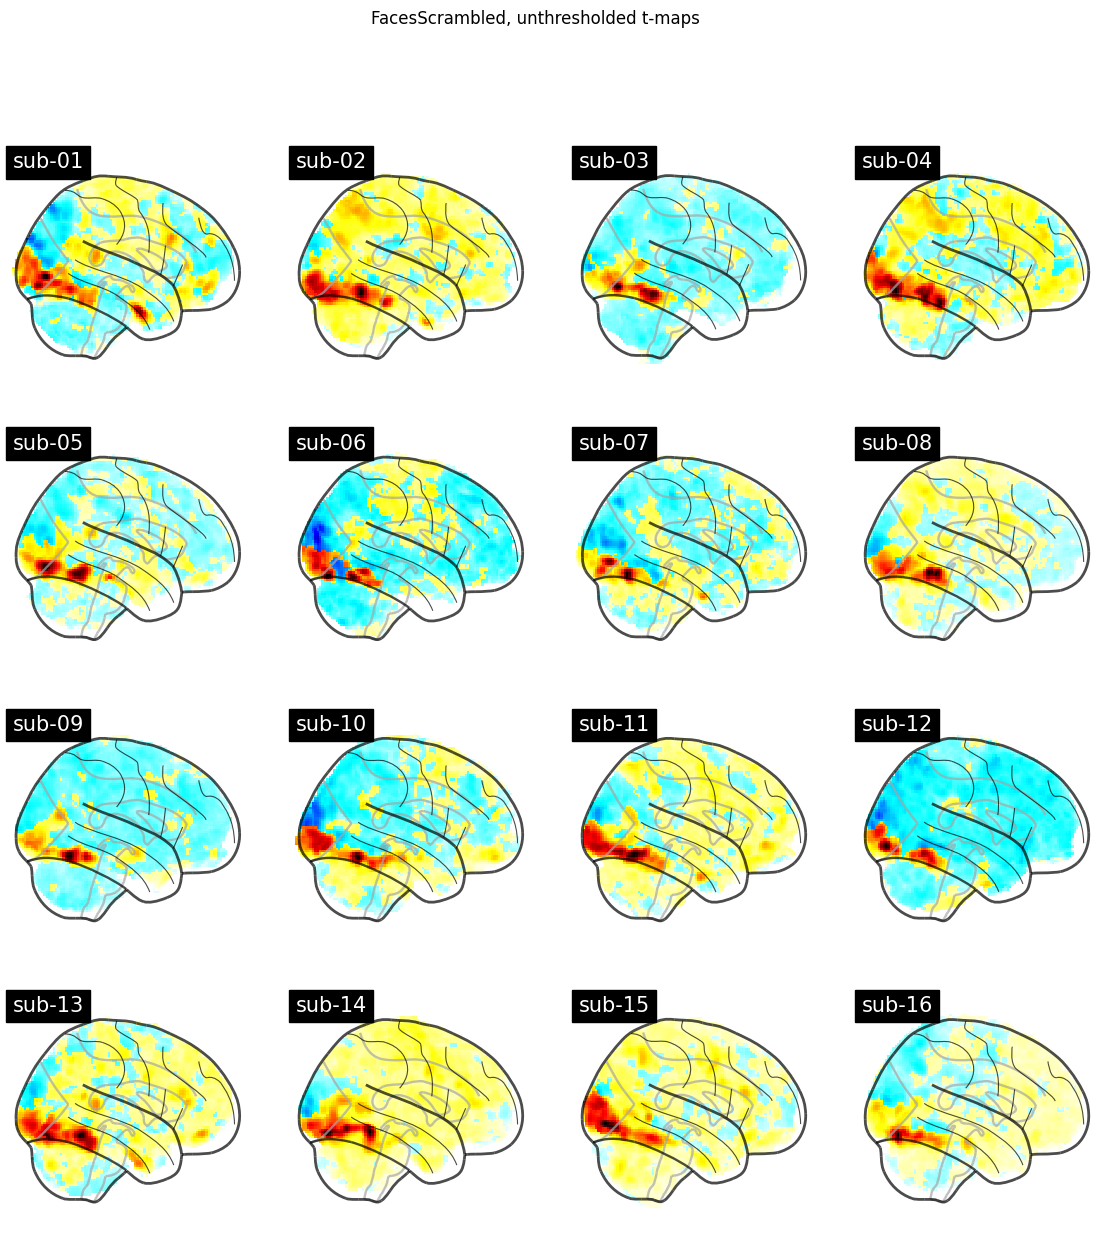

In [94]:
from nilearn import plotting
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))

for i, stat_map in enumerate(stat_files):
    plotting.plot_glass_brain(stat_map, 
                              title = 'sub-' + subjects[i],
                              axes = axes[int(i / 4), int(i % 4)],
                              plot_abs = False, 
                              display_mode='x')
fig.suptitle(contrast + ', unthresholded t-maps')
plotting.show()

## Estimate second level model

### Design matrix

The next step includes the definition of a `design matrix`. Here we will want to run a simple `one-sample t-test`. We just need to indicate as many `1` as we have subjects with first-level results.

In [95]:
import pandas as pd
design_matrix = pd.DataFrame(
    [1] * len(stat_files),
    columns=['intercept'])
design_matrix

intercept
0           1
1           1
2           1
3           1
4           1
5           1
6           1
7           1
8           1
9           1
10          1
11          1
12          1
13          1
14          1
15          1

### Model specification and fit

In [96]:
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(smoothing_fwhm = 8.0)
second_level_model = second_level_model.fit(
    stat_files,
    design_matrix = design_matrix)

### Contrast estimation

In [97]:
z_map = second_level_model.compute_contrast(output_type='z_score')

### Thresholding and plotting

#### p < .001 uncorrected (false positive rate)

Uncorrected p<.001 threshold: 3.090


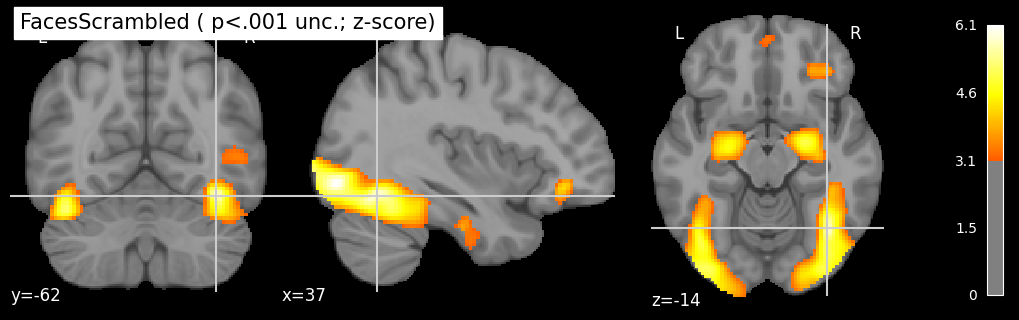

In [98]:
from nilearn.glm.thresholding import threshold_stats_img

cluster_map, threshold = threshold_stats_img(
    z_map, 
    alpha = 0.001, 
    height_control = 'fpr', 
    cluster_threshold = 0,
    two_sided = False
)

# displaying on mni152 template brain
from nilearn.datasets import load_mni152_template
template = load_mni152_template()

print('Uncorrected p<.001 threshold: %.3f' % threshold)
plotting.plot_stat_map(
    cluster_map, 
    threshold = threshold,       
    display_mode = 'ortho',
    cut_coords = [37,-62,-14],
    black_bg = True,
    bg_img = template,
    title = contrast + ' ( p<.001 unc.; z-score)')

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

#### p < .05 FWE-corrected (but on the number of voxels!)

FWE p<.05 threshold: 5.064


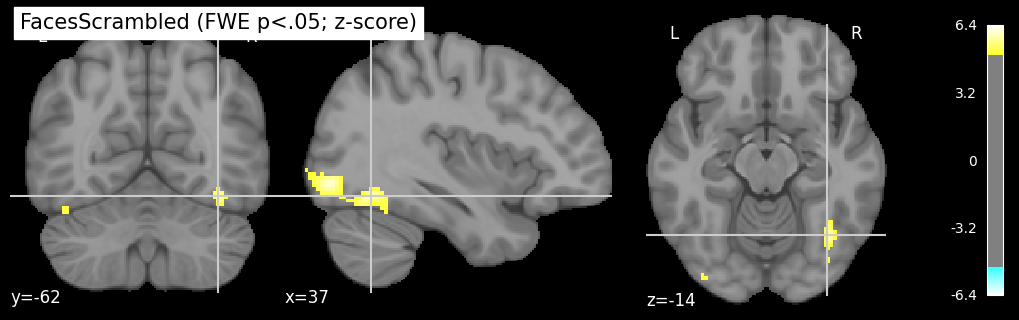

In [99]:
_, threshold = threshold_stats_img(
    z_map, 
    alpha = 0.05, 
    height_control = 'bonferroni', 
    cluster_threshold = 0,
    two_sided = False
)

print('FWE p<.05 threshold: %.3f' % threshold)
plotting.plot_stat_map(
    z_map, 
    threshold = threshold,       
    display_mode = 'ortho',
    cut_coords = [37,-62,-14],
    black_bg = True,
    bg_img = template,
    title = contrast + ' (FWE p<.05; z-score)')

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

**Bonferroni correction on the number of voxels is not not appropriate for fMRI data!**

The Bonferroni correction, when applied directly to the number of voxels, is not appropriate for fMRI data. This is because neuroimaging data typically have spatially correlated data points, which violate the Bonferroni assumption of independent tests.

In Nilearn, Bonferroni correction is applied to the number of voxels, but this approach might not be ideal for the reasons mentioned. As an alternative, neuroscientists have developed **Random Field Theory** (RFT). This method accounts for the spatial correlation by applying multiple comparison correction in a way that considers the smoothness of the data. Specifically, the correction is applied to the number of '***resels'*** (RESolution ELements), rather than the raw number of voxels. However, it's important to note that this RFT-based approach is not implemented in Nilearn. At the second level, Nilearn provides an option for non-parametric inference with permutation testing, which is a more suitable approach for fMRI data when considering the spatial correlation of voxels. 

#### Permutation test, voxel-level error control

Taken from Nilearn example [here](https://nilearn.github.io/dev/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-one-sample-test-py
)

In [100]:
from nilearn.glm.second_level import non_parametric_inference

out_dict = non_parametric_inference(
    stat_files,
    design_matrix = design_matrix,
    model_intercept = True,
    n_perm = 10000, 
    two_sided_test = False,
    n_jobs = 12,
    threshold = 0.001 # cluster level threshold; enables cluster-level inference
)
print(out_dict.keys())

/home/da05/.conda/envs/fMRI/lib/python3.10/site-packages/nilearn/mass_univariate/permuted_least_squares.py:993: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/home/da05/.conda/envs/fMRI/lib/python3.10/site-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


dict_keys(['t', 'logp_max_t', 'size', 'logp_max_size', 'mass', 'logp_max_mass'])


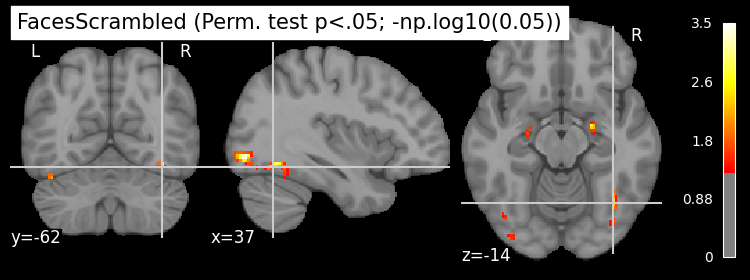

In [101]:
plotting.plot_stat_map(
    out_dict['logp_max_t'], 
    threshold = -np.log10(0.05),       
    display_mode = 'ortho',
    cut_coords = [37,-62,-14],
    black_bg = True,
    bg_img = template,
    title = contrast + ' (Perm. test p<.05; -np.log10(0.05))')

We can also look at a 3D brain using `plotly`.

In [102]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()

view = plotting.view_img_on_surf(out_dict['logp_max_t'], 
    threshold = -np.log10(0.05))
# view.open_in_browser()
view

### Summary results

We can use ['atlasreader'](https://github.com/miykael/atlasreader) package to get summary results (peak table, cluster table, .png images of each cluster). 

In [103]:
from atlasreader import create_output

# generate and save atlasreader output
outdir = os.path.join(results_path, 'group-level', 'permutation', 'atlasreader', 'FacesScrambled')

create_output(
    out_dict['logp_max_t'], 
    cluster_extent = 20, 
    voxel_thresh = -np.log10(0.05),
    direction = 'pos',
    outdir = outdir
)

#### Peak table for Faces>Scrambled (Perm. test p<.05)

In [104]:
# display the peak table
peaks = glob.glob(os.path.join(outdir, '*_peaks.csv'))
display(pd.read_csv(peaks[0]))

cluster_id  peak_x  peak_y  peak_z  peak_value  volume_mm              aal   
0         1.0    37.5   -84.5    -8.5    3.522922     2128.0  Occipital_Inf_R  \
1         2.0   -32.5   -92.5    -8.5    2.958651      872.0  Occipital_Inf_L   
2         3.0    37.5   -60.5   -12.5    3.096953      488.0       Fusiform_R   
3         4.0   -42.5   -60.5   -22.5    2.769594      224.0       Fusiform_L   
4         5.0    21.5    -6.5   -14.5    2.823952      200.0       Amygdala_R   

              desikan_killiany   
0  Right-Cerebral-White-Matter  \
1   Left-Cerebral-White-Matter   
2  Right-Cerebral-White-Matter   
3                      Unknown   
4               Right-Amygdala   

                                      harvard_oxford  
0  48.0% Right_Lateral_Occipital_Cortex_inferior_...  
1  49.0% Left_Occipital_Pole; 21.0% Left_Lateral_...  
2  23.0% Right_Temporal_Occipital_Fusiform_Cortex...  
3  38.0% Left_Temporal_Occipital_Fusiform_Cortex;...  
4                               99.0% Right_Amygdala

#### Peak table for Faces>Scrambled (FWE p<.05)

In [105]:
# generate and save also atlasreader output
outdir = os.path.join(results_path, 'group-level', 'fwe', 'atlasreader', 'FacesScrambled')
create_output(
    z_map, 
    cluster_extent = 20, 
    voxel_thresh = threshold,
    direction = 'pos',
    outdir = outdir
)
# find peak table
peaks = glob.glob(os.path.join(outdir, '*_peaks.csv'))

# display the table
display(pd.read_csv(peaks[0]))

cluster_id  peak_x  peak_y  peak_z  peak_value  volume_mm              aal   
0         1.0    35.5   -86.5    -8.5    6.100534     3416.0  Occipital_Inf_R  \
1         2.0   -34.5   -92.5    -8.5    6.003581     1752.0  Occipital_Inf_L   
2         3.0    37.5   -64.5   -14.5    5.874251      864.0       Fusiform_R   

              desikan_killiany   
0  Right-Cerebral-White-Matter  \
1   Left-Cerebral-White-Matter   
2  Right-Cerebral-White-Matter   

                                      harvard_oxford  
0  41.0% Right_Lateral_Occipital_Cortex_inferior_...  
1  52.0% Left_Occipital_Pole; 21.0% Left_Lateral_...  
2  42.0% Right_Occipital_Fusiform_Gyrus; 7.0% Rig...